# AMDA termpaper: **normalizing flows**
## Plotting for Exercise 1
### *by Lennart Böhm*
---

##### Load packages

In [3]:
import os
import sys
import numpy as np
module_path = os.path.abspath(os.path.join('normalizing-flows/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data.plot_samples import plot_samples_2d
from data.visu_density import plot_heatmap_2d
from data.dataset_loader import load_and_preprocess_uci
from normalizingflows.flow_catalog import NeuralSplineFlow
from utils.train_utils import train_density_no_tf, train_density_estimation, shuffle_split
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
import time
from utils.train_utils import sanity_check

/Users/lenny/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensorflow:  2.4.1
tensorflow-probability:  0.12.2


## Read data [Jake van der Plas/astroML]

In [4]:
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
#----------------------------------

X, y = fetch_rrlyrae_combined()

# put them into one array
DATA = np.concatenate((X, y.reshape(y.size, 1)), axis=1)

# train, val, test; preserves tensor shape WITH BOTH STARS AND RRLYRAE
data_train_all, data_validate_all, data_test_all = shuffle_split(DATA, TRAIN_SPLIT, VAL_SPLIT) 

# for the CLASSIFIER in ex. 3
test_data = data_test_all

2022-08-23 15:56:29.944971: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-23 15:56:29.945903: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


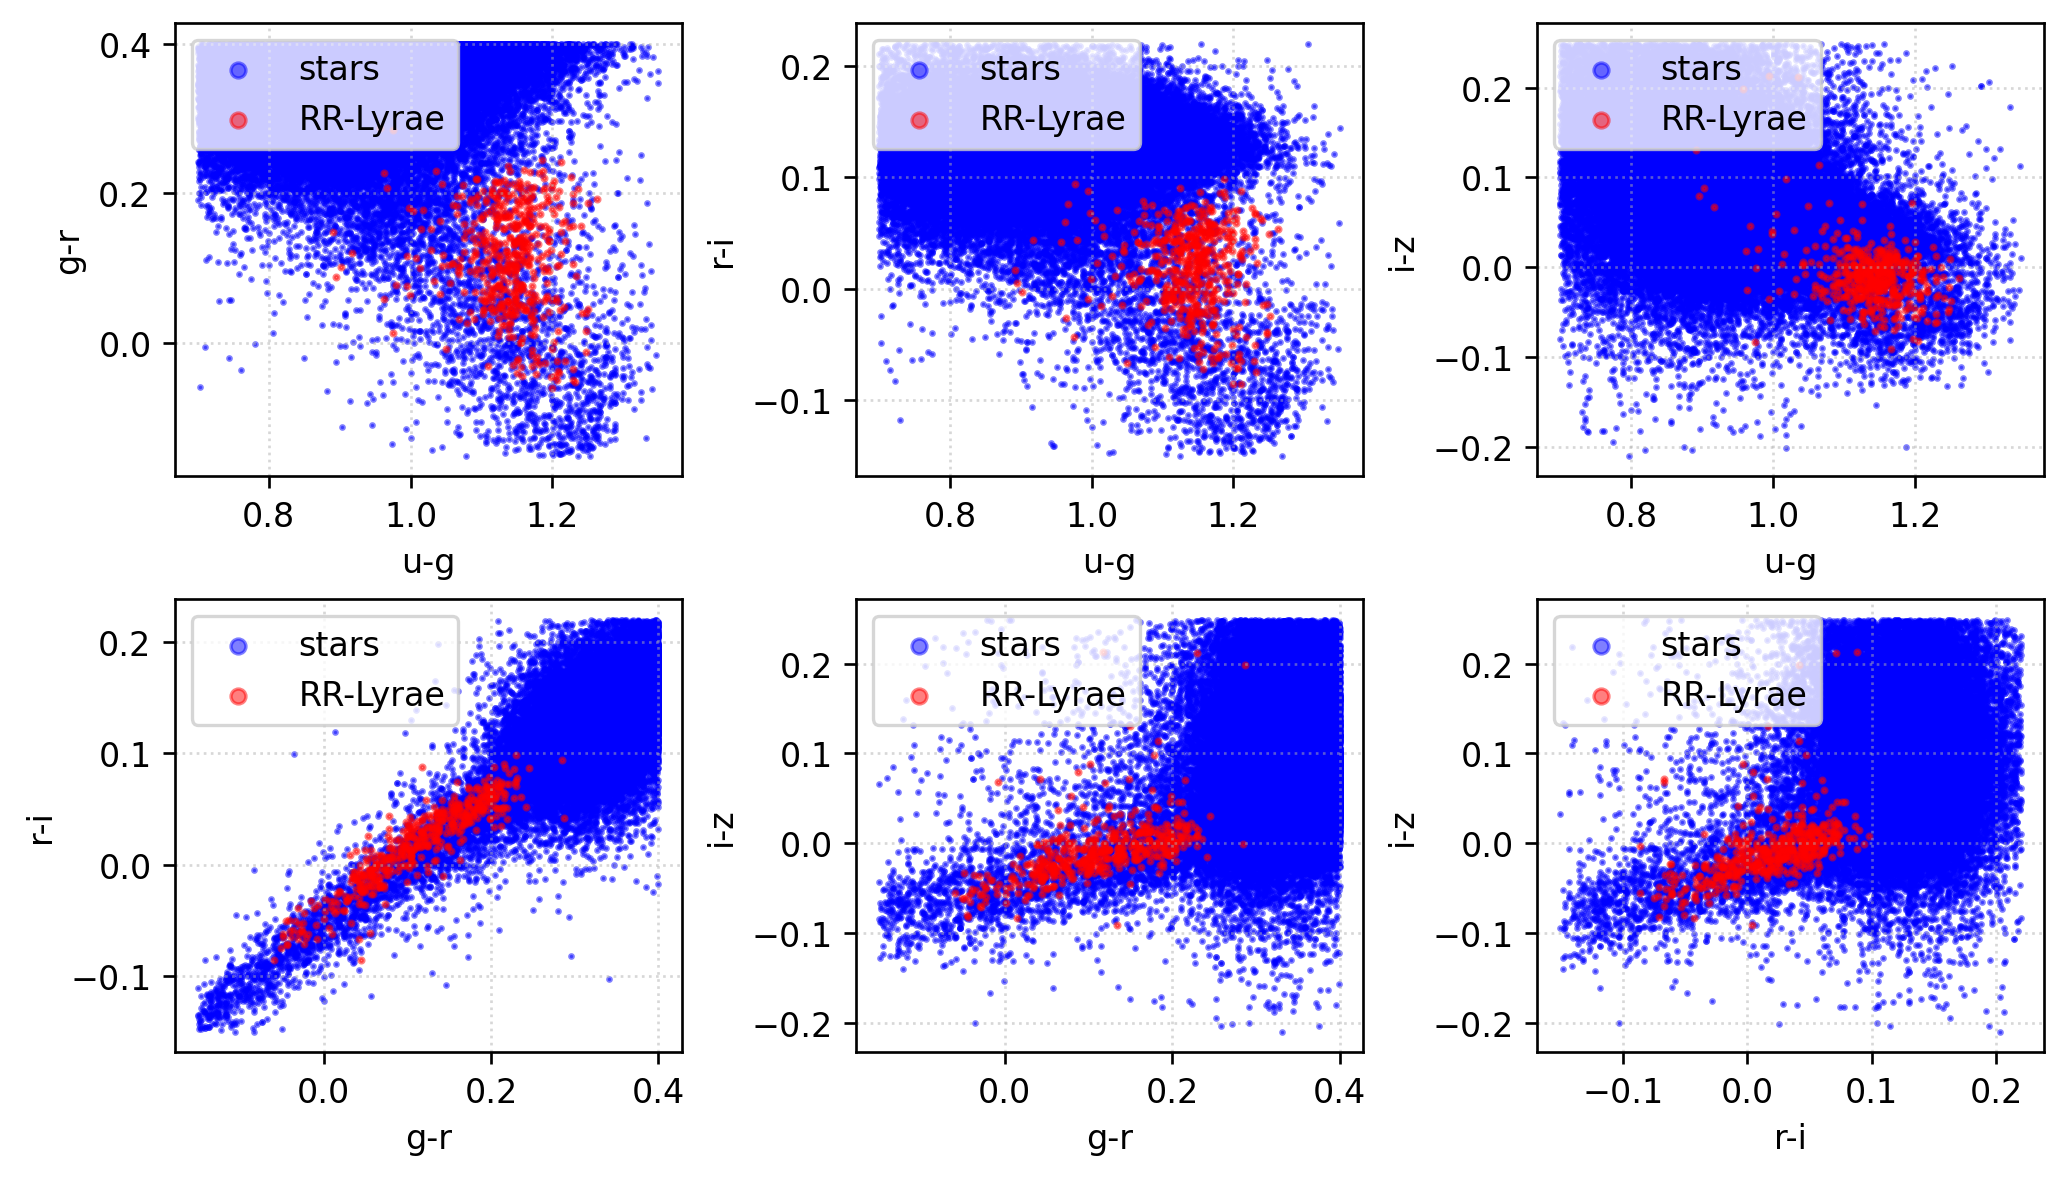

In [16]:
from astroML.datasets import fetch_rrlyrae_combined
import numpy as np
import matplotlib.pyplot as plt

# names of the features, i. e. color magnitudes
features = "u-g g-r r-i i-z".split()

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()

# all_mean = X.mean(axis=0)
# all_std = X.std(axis=0)
# # Manual Batch Normalization
# X = (X - all_mean) / all_std

stars = (y == 0)
rrlyrae = (y == 1)

# # make six subplots
# fig, axes = plt.subplots(2, 2, 
#                          figsize=(32/3,6), 
#                          dpi=200, 
#                         #  sharex="col", 
#                         #  sharey="row"
#                          constrained_layout=True)

# axes = axes.flatten() # 1D array

# # # set the spacing between subplots
# # plt.subplots_adjust(wspace=0.2, 
# #                     hspace=0.2)

# ax_cnt = 0

# for i in range(len(features)):
#     # for j in range(i+1, len(features)):
#     ax = axes[ax_cnt]
#     # ax.plot(X[stars, i], X[stars, j], '.', ms=2, c='b', label='stars')
#     # ax.plot(X[rrlyrae, i], X[rrlyrae, j], '.', ms=2, c='r', label='RR-Lyrae')

#     ax.hist(X[rrlyrae, i], histtype="step", label="RR Lyrae", density=True)
#     ax.hist(X[stars, i], histtype="step", label="stars", density=True)
#     ax.set_xlabel(features[i])
#     # ax.set_ylabel(features[j])

#     ax.grid(alpha=.5, linestyle=":")
#     ax.legend(loc="upper left")

#     ax_cnt += 1
        
# fig.suptitle("All possible color magnitude-combinations", fontsize=24)
# plt.show()


# make six subplots
fig, axes = plt.subplots(2, 3, 
                         figsize=(8.5, 4.8), 
                         dpi=240, 
                        #  sharex="col", 
                        #  sharey="row"
                         constrained_layout=True)

axes = axes.flatten() # 1D array

# # set the spacing between subplots
# plt.subplots_adjust(wspace=0.2, 
#                     hspace=0.2)

ax_cnt = 0

for i in range(len(features)):
    for j in range(i+1, len(features)):
        ax = axes[ax_cnt]
        ax.scatter(X[stars, i], X[stars, j], s=1, c='b', alpha=.5, label='stars')
        ax.scatter(X[rrlyrae, i], X[rrlyrae, j], s=2, c='r', alpha=.5, label='RR-Lyrae')

        ax.set_xlabel(features[i])
        ax.set_ylabel(features[j])

        ax.grid(alpha=.5, linestyle=":")
        lgnd = ax.legend(loc="upper left")
        lgnd.legendHandles[0]._sizes = [20]
        lgnd.legendHandles[1]._sizes = [20]
        lgnd.legendHandles[0]._alphas = [1]
        lgnd.legendHandles[1]._alphas = [1]

        ax_cnt += 1
        
# fig.suptitle("All possible color magnitude-combinations", fontsize=24)
plt.savefig("figs/raw_data.png", transparent=False)

In [28]:
from astroML.plotting import MultiAxes

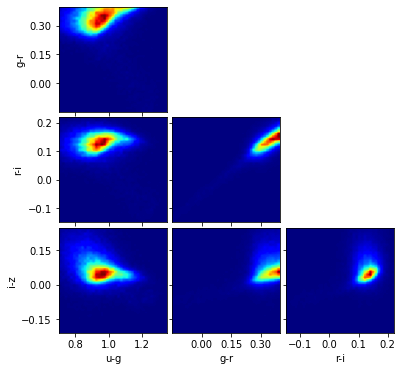

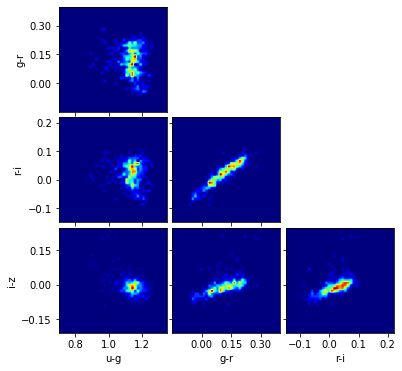

In [34]:
bins = np.linspace(X.min(axis=0), X.max(axis=0), 40).T

ax = MultiAxes(4, wspace=0.05, hspace=0.05,
               fig=plt.figure(figsize=(6, 6)))
ax.density(X[y==0], bins, cmap=plt.cm.jet)
ax.set_labels(features)
ax.set_locators(plt.MaxNLocator(4))

plt.show()

bins = np.linspace(X.min(axis=0), X.max(axis=0), 40).T

ax = MultiAxes(4, wspace=0.05, hspace=0.05,
               fig=plt.figure(figsize=(6, 6)))
ax.density(X[y==1], bins, cmap=plt.cm.jet)
ax.set_labels(features)
ax.set_locators(plt.MaxNLocator(4))

plt.show()

In [1]:
"""
Multi-panel plotting
"""
from copy import deepcopy
import numpy as np
from astroML.datasets import fetch_rrlyrae_combined

class MultiAxes:
    """Visualize Multiple-dimensional data

    This class enables the visualization of multi-dimensional data, using
    a triangular grid of 2D plots.

    Parameters
    ----------
    ndim : integer
        Number of data dimensions
    inner_labels : bool
        If true, then label the inner axes.  If false, then only the outer
        axes will be labeled
    fig : matplotlib.Figure
        if specified, draw the plot on this figure.  Otherwise, use the
        current active figure.
    left, bottom, right, top, wspace, hspace : floats
        these parameters control the layout of the plots.  They behave have
        an identical effect as the arguments to plt.subplots_adjust.  If not
        specified, default values from the rc file will be used.

    Examples
    --------
    A grid of scatter plots can be created as follows::

        x = np.random.normal((4, 1000))
        R = np.random.random((4, 4))  # projection matrix
        x = np.dot(R, x)
        ax = MultiAxes(4)
        ax.scatter(x)
        ax.set_labels(['x1', 'x2', 'x3', 'x4'])

    Alternatively, the scatter plot can be visualized as a density::

        ax = MultiAxes(4)
        ax.density(x, bins=[20, 20, 20, 20])
    """
    def __init__(self, ndim, inner_labels=False,
                 fig=None,
                 left=None, bottom=None,
                 right=None, top=None,
                 wspace=None, hspace=None):
        # Import here so that testing with Agg will work
        from matplotlib import pyplot as plt
        if fig is None:
            fig = plt.gcf()
        self.fig = fig

        self.ndim = ndim
        self.inner_labels = inner_labels

        self._update('left', left)
        self._update('bottom', bottom)
        self._update('right', right)
        self._update('top', top)
        self._update('wspace', wspace)
        self._update('hspace', hspace)

        self.axes = self._draw_panels()


    def _update(self, s, val):
        # Import here so that testing with Agg will work
        from matplotlib import rcParams
        if val is None:
            val = getattr(self, s, None)
            if val is None:
                key = 'figure.subplot.' + s
                val = rcParams[key]
        setattr(self, s, val)

    def _check_data(self, data):
        data = np.asarray(data)
        if data.ndim != 2:
            raise ValueError("data dimension should be 2")
        if data.shape[1] != self.ndim:
            raise ValueError("leading dimension of data should match ndim")
        return data

    def _draw_panels(self):
        # Import here so that testing with Agg will work
        from matplotlib import pyplot as plt
        if self.top <= self.bottom:
            raise ValueError('top must be larger than bottom')
        if self.right <= self.left:
            raise ValueError('right must be larger than left')

        ndim = self.ndim

        panel_width = ((self.right - self.left)
                       / (ndim - 1 + self.wspace * (ndim - 2)))
        panel_height = ((self.top - self.bottom)
                        / (ndim - 1 + self.hspace * (ndim - 2)))

        full_panel_width = (1 + self.wspace) * panel_width
        full_panel_height = (1 + self.hspace) * panel_height

        axes = np.empty((ndim, ndim), dtype=object)
        axes.fill(None)

        for j in range(1, ndim):
            for i in range(j):
                left = self.left + i * full_panel_width
                right = self.bottom + (ndim - 1 - j) * full_panel_height
                ax = self.fig.add_axes([left, right,
                                        panel_width, panel_height])
                axes[i, j] = ax

        if not self.inner_labels:
            # remove unneeded x labels
            for i in range(ndim):
                for j in range(ndim - 1):
                    ax = axes[i, j]
                    if ax is not None:
                        ax.xaxis.set_major_formatter(plt.NullFormatter())

            # remove unneeded y labels
            for i in range(1, ndim):
                for j in range(ndim):
                    ax = axes[i, j]
                    if ax is not None:
                        ax.yaxis.set_major_formatter(plt.NullFormatter())

        return np.asarray(axes, dtype=object)

    def set_limits(self, limits):
        """Set the axes limits

        Parameters
        ----------
        limits : list of tuples
            a list of plot limits for each dimension, each in the form
            (xmin, xmax).  The length of `limits` should match the data
            dimension.
        """
        if len(limits) != self.ndim:
            raise ValueError("limits do not match number of dimensions")

        for i in range(self.ndim):
            for j in range(self.ndim):
                ax = self.axes[i, j]
                if ax is not None:
                    ax.set_xlim(limits[i])
                    ax.set_ylim(limits[j])

    def set_labels(self, labels):
        """Set the axes labels

        Parameters
        ----------
        labels : list of strings
            a list of plot limits for each dimension.  The length of `labels`
            should match the data dimension.
        """
        if len(labels) != self.ndim:
            raise ValueError("labels do not match number of dimensions")

        for i in range(self.ndim):
            ax = self.axes[i, self.ndim - 1]
            if ax is not None:
                ax.set_xlabel(labels[i])

        for j in range(self.ndim):
            ax = self.axes[0, j]
            if ax is not None:
                ax.set_ylabel(labels[j])

    def set_locators(self, locators):
        """Set the tick locators for the plots

        Parameters
        ----------
        locators : list or plt.Locator object
            If a list, then the length should match the data dimension.  If
            a single Locator instance, then each axes will be given the
            same locator.
        """
        # Import here so that testing with Agg will work
        from matplotlib import pyplot as plt
        if isinstance(locators, plt.Locator):
            locators = [deepcopy(locators) for i in range(self.ndim)]
        elif len(locators) != self.ndim:
            raise ValueError("locators do not match number of dimensions")

        for i in range(self.ndim):
            for j in range(self.ndim):
                ax = self.axes[i, j]
                if ax is not None:
                    ax.xaxis.set_major_locator(locators[i])
                    ax.yaxis.set_major_locator(locators[j])

    def set_formatters(self, formatters):
        """Set the tick formatters for the outer edge of plots

        Parameters
        ----------
        formatterss : list or plt.Formatter object
            If a list, then the length should match the data dimension.  If
            a single Formatter instance, then each axes will be given the
            same locator.
        """
        # Import here so that testing with Agg will work
        from matplotlib import pyplot as plt
        if isinstance(formatters, plt.Formatter):
            formatters = [deepcopy(formatters) for i in range(self.ndim)]
        elif len(formatters) != self.ndim:
            raise ValueError("formatters do not match number of dimensions")

        for i in range(self.ndim):
            ax = self.axes[i, self.ndim - 1]
            if ax is not None:
                ax.xaxis.set_major_formatter(formatters[i])

        for j in range(self.ndim):
            ax = self.axes[0, j]
            if ax is not None:
                ax.xaxis.set_major_formatter(formatters[i])

    def plot(self, data, *args, **kwargs):
        """Plot data

        This function calls plt.plot() on each axes.  All arguments or
        keyword arguments are passed to the plt.plot function.

        Parameters
        ----------
        data : ndarray
            shape of data is [n_samples, ndim], and ndim should match that
            passed to the MultiAxes constructor.
        """
        data = self._check_data(data)

        for i in range(self.ndim):
            for j in range(self.ndim):
                ax = self.axes[i, j]
                if ax is None:
                    continue
                ax.plot(data[:, i], data[:, j], *args, **kwargs)

    def scatter(self, data, *args, **kwargs):
        """Scatter plot data

        This function calls plt.scatter() on each axes.  All arguments or
        keyword arguments are passed to the plt.scatter function.

        Parameters
        ----------
        data : ndarray
            shape of data is [n_samples, ndim], and ndim should match that
            passed to the MultiAxes constructor.
        """
        data = self._check_data(data)

        for i in range(self.ndim):
            for j in range(self.ndim):
                ax = self.axes[i, j]
                if ax is None:
                    continue
                ax.scatter(data[:, i], data[:, j], *args, **kwargs)

    def density(self, data, bins=20, **kwargs):
        """Density plot of data

        This function calls np.histogram2D to bin the data in each axes, then
        calls plt.imshow() on the result.  All extra arguments or
        keyword arguments are passed to the plt.imshow function.

        Parameters
        ----------
        data : ndarray
            shape of data is [n_samples, ndim], and ndim should match that
            passed to the MultiAxes constructor.
        bins : int, array, list of ints, or list of arrays
            specify the bins for each dimension. If bins is a list, then the
            length must match the data dimension
        """
        data = self._check_data(data)

        if not hasattr(bins, '__len__'):
            bins = [bins for i in range(self.ndim)]
        elif len(bins) != self.ndim:
            bins = [bins for i in range(self.ndim)]

        for i in range(self.ndim):
            for j in range(self.ndim):
                ax = self.axes[i, j]
                if ax is None:
                    continue

                H, xbins, ybins = np.histogram2d(data[:, i], data[:, j],
                                                 (bins[i], bins[j]))
                ax.imshow(H.T, origin='lower', aspect='auto',
                          extent=(xbins[0], xbins[-1], ybins[0], ybins[-1]),
                          **kwargs)

                ax.set_xlim(xbins[0], xbins[-1])
                ax.set_ylim(ybins[0], ybins[-1])
    def contour(self, data, *args, **kwargs):
        """Scatter plot data

        This function calls plt.scatter() on each axes.  All arguments or
        keyword arguments are passed to the plt.scatter function.

        Parameters
        ----------
        data : ndarray
            shape of data is [n_samples, ndim], and ndim should match that
            passed to the MultiAxes constructor.
        """
        data = self._check_data(data)

        for i in range(self.ndim):
            for j in range(self.ndim):
                ax = self.axes[i, j]
                if ax is None:
                    continue
                H, xbins, ybins = np.histogram2d(data[:, i], data[:, j], bins=30)
                
                extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]
                
                ax.contour(H.T, extent=extent, linewidths=1, *args, **kwargs)




In [2]:
# import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# import pandas as pd
from cycler import cycler
# import astropy.constants as const
# from scipy.optimize import curve_fit
# from scipy.odr import Model, ODR, RealData

textwidth=1.0

# fonts
fsize = 14*textwidth
tsize = 10*textwidth

# lines
lwidth = 1.5
lhandle = 2.0

# figsize
fwidth = 6.05434*textwidth
fheight = 4.540755*textwidth

colors = cycler('color', ['navy', 'orange', 'green', 'red', 'm', 'deepskyblue'])

plt.rcParams['text.usetex'] = True

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (fwidth, fheight)
plt.rcParams['axes.prop_cycle'] = colors
plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['xtick.minor.width'] = 1.0
plt.rcParams['xtick.major.size'] = 8.0
plt.rcParams['xtick.minor.size'] = 4.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['ytick.minor.width'] = 1.0
plt.rcParams['ytick.major.size'] = 8.0
plt.rcParams['ytick.minor.size'] = 4.0
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"

plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

def fit(f, x, y, p0, sx=None, sy=None):
	"""
	fit unsing scipy.odr
	:params:
	f : func(p, x) with p a list of params
	x : x data
	y : y data
	sx: x error
	sy: y error
	p0: initial guesses
	"""
	function = Model(f)

	data = RealData(x, y, sx=sx, sy=sy)

	odr = ODR(data, function, beta0=p0)

	out = odr.run()

	print(out.pprint())

	return out.beta, out.sd_beta




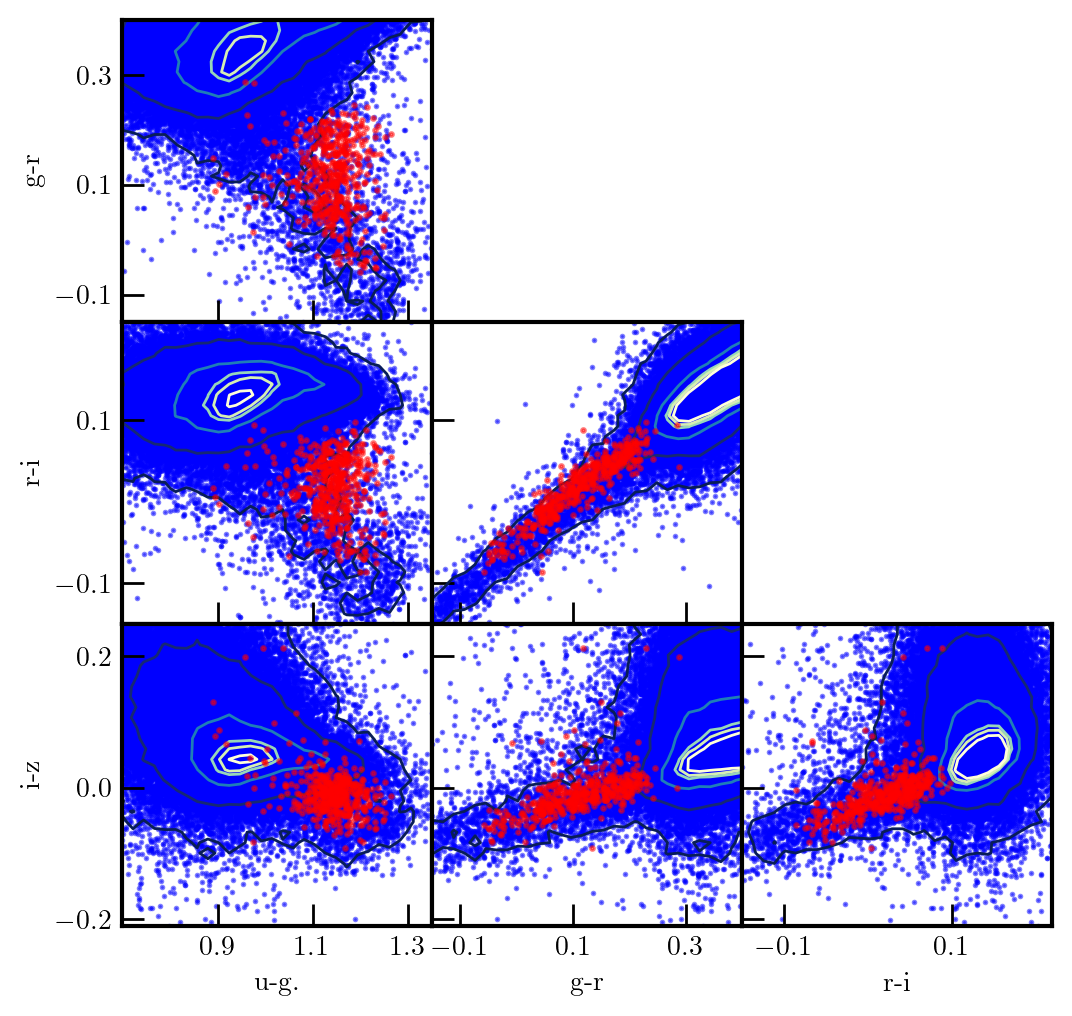

In [5]:
X, y = fetch_rrlyrae_combined()
features = "u-g. g-r r-i i-z".split()

fig = plt.figure(figsize=(6, 6), dpi=200)

ax = MultiAxes(4, wspace=0.0, hspace=0.0,
               fig=fig)
ax.scatter(X[y==0], s=1, c='b', alpha=.5)
# ax.contour(X[y==0], levels=[10, 100, 500, 1000, 1200, 1500], cmap=plt.cm.winter)
ax.contour(X[y==0], levels=[10, 100, 500, 1000, 1200, 1500], cmap=plt.cm.YlGnBu_r)
ax.scatter(X[y==1], s=2, c='r', alpha=.5, zorder=11)
# ax.contour(X[y==1], levels=[1.5, 3], zorder=15)
ax.set_labels(features)
ax.set_locators([plt.FixedLocator(np.arange(0.7, 1.4, .2))
                ,plt.FixedLocator(np.arange(-.1, .4, .2))
                ,plt.FixedLocator(np.arange(-.1, .4, .2))
                ,plt.FixedLocator(np.arange(-.2, .3, .2))])


plt.savefig("figs/raw_data_alt.png")

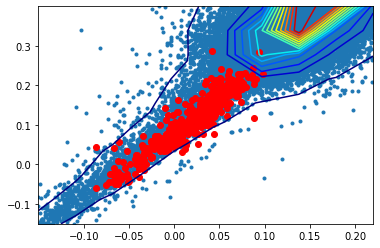

In [76]:
from astroML.plotting import scatter_contour

scatter_contour(X[:, 2][y==0], X[:, 1][y==0], filled_contour=False, levels=15, contour_args={"cmap":plt.cm.jet})
plt.scatter(X[:, 2][y==1], X[:, 1][y==1], c="r")